In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Qt5Agg')
%matplotlib widget
import numpy as np
import torch
import math
import trimesh

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
# bunny_mesh = trimesh.load('bun_zipper_res4.ply')
# assert isinstance(bunny_mesh, trimesh.Trimesh), "Loaded object should be a Trimesh"
# rotation_matrix = trimesh.transformations.rotation_matrix(
#     np.radians(90), [1, 0, 0])
# bunny_mesh.apply_transform(rotation_matrix)

# vertices = bunny_mesh.vertices
# faces = bunny_mesh.faces

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_trisurf(vertices[:, 0], vertices[:, 1], faces, vertices[:, 2], shade=True)
# ax.set_xlabel('X Axis')
# ax.set_ylabel('Y Axis')
# ax.set_zlabel('Z Axis')
# plt.show()

- implicity calculate gradient instead of explicity store each position's IOR. The wavefront propagation stage doesn't need grid and the position of wavefront points doesn't need to be inside the grid.

-  try to test on random position random direction. 

- store results of propagation to generate irradiance in grid (do not need points afterwards)

## Initialize

In [3]:
num_x, num_y, num_z = 40, 40, 40

ior_field = torch.ones((num_x, num_y, num_z), dtype=torch.float16, device=device)
absorb_coeff = torch.zeros((num_x, num_y, num_z), dtype=torch.float16, device=device)
scatter_coeff = torch.zeros((num_x, num_y, num_z), dtype=torch.float16, device=device)

# Sphere params
radius = 12

sphere_ior = 1.1
sphere_absorb_coeff = 0.01
sphere_scatter_coeff = 0.01

# Wall params
wall_thickness = 4

wall_ior = 1.7
wall_absorb_coeff = 0.5
wall_scatter_coeff = 0.5

# Create sphere
center = (num_x//2, num_y//2, radius + wall_thickness + 1)
x, y, z = torch.meshgrid(torch.arange(num_x), torch.arange(num_y), torch.arange(num_z), indexing='ij')
sphere_mask = ((x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2 <= radius**2).to(device)


ior_field[sphere_mask] = sphere_ior
absorb_coeff[sphere_mask] = sphere_absorb_coeff
scatter_coeff[sphere_mask] = sphere_scatter_coeff

# Create walls
ior_field[:, :, -wall_thickness:] = wall_ior    # ceiling
absorb_coeff[:, :, -wall_thickness:] = wall_absorb_coeff
scatter_coeff[:, :, -wall_thickness:] = wall_scatter_coeff

ior_field[:, :, :wall_thickness] =wall_ior      # floor
absorb_coeff[:, :, :wall_thickness] = wall_absorb_coeff
scatter_coeff[:, :, :wall_thickness] = wall_scatter_coeff

ior_field[:, :wall_thickness, :] = wall_ior     # front
absorb_coeff[:, :wall_thickness, :] = wall_absorb_coeff
scatter_coeff[:, :wall_thickness, :] = wall_scatter_coeff

ior_field[:, -wall_thickness:, :] = wall_ior    # back
absorb_coeff[:, -wall_thickness:, :] = wall_absorb_coeff
scatter_coeff[:, -wall_thickness:, :] = wall_scatter_coeff

ior_field[:wall_thickness, :, :] = wall_ior     # left
absorb_coeff[:wall_thickness, :, :] = wall_absorb_coeff
scatter_coeff[:wall_thickness, :, :] = wall_scatter_coeff

ior_field[-wall_thickness:, :, :] = wall_ior    # right
absorb_coeff[-wall_thickness:, :, :] = wall_absorb_coeff
scatter_coeff[-wall_thickness:, :, :] = wall_scatter_coeff


# Initialize the wavefront positions and directions
def spherical_to_cartesian(theta, phi):
    """
    Convert spherical coordinates to cartesian coordinates.
    :param r: radius
    :param theta: polar angle (in degrees)
    :param phi: azimuthal angle (in degrees)
    :return: x, y, z coordinates
    """
    r = 1
    theta_rad = math.radians(theta)
    phi_rad = math.radians(phi)
    x = r * math.sin(theta_rad) * math.cos(phi_rad)
    y = r * math.sin(theta_rad) * math.sin(phi_rad)
    z = r * math.cos(theta_rad)
    return x, y, z

theta_step = 3
phi_step = 3
initial_wavefront_positions = torch.tensor([(num_x//2, num_y//2, num_z - wall_thickness - 3)], dtype=torch.float16, device=device)
initial_wavefront_directions = torch.tensor([spherical_to_cartesian(theta, phi) for theta in range(90, 180, theta_step) for phi in range(0, 360, phi_step)], dtype=torch.float16, device=device)

In [4]:
# # only plot initial_wavefront_directions
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.quiver(initial_wavefront_positions[:, 0].cpu().numpy(), initial_wavefront_positions[:, 1].cpu().numpy(), initial_wavefront_positions[:, 2].cpu().numpy(),
#             initial_wavefront_directions[:, 0].cpu().numpy(), initial_wavefront_directions[:, 1].cpu().numpy(), initial_wavefront_directions[:, 2].cpu().numpy())
# ax.set_xlabel('X Axis')
# ax.set_ylabel('Y Axis')
# ax.set_zlabel('Z Axis')
# plt.show()

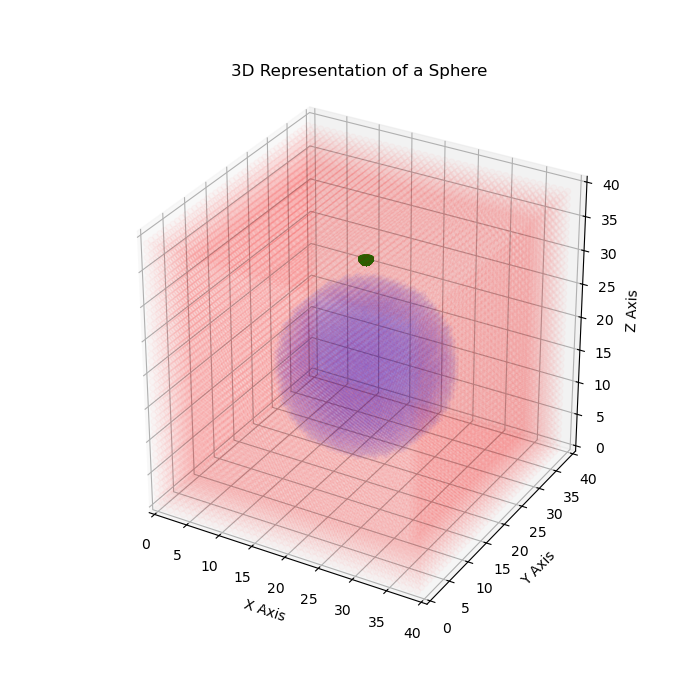

In [5]:
def show_ior_field(ior_field, initial_wavefront_positions, initial_wavefront_directions):    
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect([1,1,1])
    ax.set_xlim(0, num_x)
    ax.set_ylim(0, num_y)
    ax.set_zlim(0, num_z)

    initial_pos_np = initial_wavefront_positions.cpu().numpy()
    initial_dir_np = initial_wavefront_directions.cpu().numpy()

    # Initial wavefront
    ax.quiver(initial_pos_np[:, 0], initial_pos_np[:, 1], initial_pos_np[:, 2], 
              initial_dir_np[:, 0], initial_dir_np[:, 1], initial_dir_np[:, 2],
              length=1, color='green', normalize=True, linewidths=0.7, arrow_length_ratio=0.4, alpha=0.3)
    
    # IOR field
    ior_field = ior_field.cpu().numpy()
    x_points, y_points, z_points = np.where(ior_field == sphere_ior)
    ax.scatter(x_points, y_points, z_points, color='blue', alpha=0.02)
    x_points, y_points, z_points = np.where(ior_field == wall_ior)
    ax.scatter(x_points, y_points, z_points, color='red', alpha=0.02)
    ax.set_title("3D Representation of a Sphere")
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    plt.show()

show_ior_field(ior_field, initial_wavefront_positions, initial_wavefront_directions)

In [6]:
def compute_3d_gradients_torch(IOR):
    grad_x, grad_y, grad_z = torch.gradient(IOR)
    return grad_x, grad_y, grad_z

convex_grad_xyz_torch = compute_3d_gradients_torch(ior_field)

def visualize_gredients(convex_grad_xyz_torch):
    grad_x = convex_grad_xyz_torch[0].cpu().numpy()
    grad_y = convex_grad_xyz_torch[1].cpu().numpy()
    grad_z = convex_grad_xyz_torch[2].cpu().numpy()

    plt.figure(figsize=(8, 3))
    plt.subplot(131)
    plt.imshow(grad_x[:, :, num_z // 2], cmap='gray')  # Z axis cut-through
    plt.title('Gradient along x-axis')
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    plt.subplot(132)
    plt.imshow(grad_y[num_y // 2, :, :], cmap='gray')  # Y axis cut-through
    plt.title('Gradient along y-axis')
    plt.xlabel('x-axis')
    plt.ylabel('z-axis')
    plt.subplot(133)
    plt.imshow(grad_z[:, num_x // 2, :], cmap='gray')  # X axis cut-through
    plt.title('Gradient along z-axis')
    plt.xlabel('y-axis')
    plt.ylabel('z-axis')
    plt.tight_layout()
    plt.show()

# visualize_gredients(convex_grad_xyz_torch)

## Wavefront propagation

In [7]:
# @torch.jit.script
def update_wavefront(pos, dir, grad_xyz, IOR, delta_t):
    indices = pos.int()

    # Obtain the refractive index at the current position
    n = IOR[indices[:, 0].clamp(0, IOR.shape[0] - 1),
            indices[:, 1].clamp(0, IOR.shape[1] - 1),
            indices[:, 2].clamp(0, IOR.shape[2] - 1)]

    # Calculate the new position and direction of the wavefront
    new_pos = pos + delta_t * dir / (n**2).unsqueeze(1)

    # Create a mask to ensure that the wavefront stays within the boundaries of the IOR field
    mask = (new_pos[:, 0] >= 0) & (new_pos[:, 0] < IOR.shape[0]) & \
           (new_pos[:, 1] >= 0) & (new_pos[:, 1] < IOR.shape[1]) & \
           (new_pos[:, 2] >= 0) & (new_pos[:, 2] < IOR.shape[2])
    mask = mask.unsqueeze(1)  # Add a dimension to match the shape of new_pos

    # only update the positions that are within the IOR boundaries
    new_pos = torch.where(mask, new_pos, pos)
    new_dir = torch.where(mask, dir + delta_t * torch.stack([grad_xyz[0][indices[:, 0], indices[:, 1], indices[:, 2]],  grad_xyz[1][indices[:, 0], indices[:, 1], indices[:, 2]], grad_xyz[2][indices[:, 0], indices[:, 1], indices[:, 2]]], dim=1) / n.unsqueeze(1), dir)

    return new_pos, new_dir


def simulate_wavefront_propagation(cur_IOR, grad_xyz, initial_wavefront_pos, initial_wavefront_dir, num_steps=100, delta_t=1.0):
    wavefront_pos_list = [initial_wavefront_pos]
    wavefront_dir_list = [initial_wavefront_dir]
    # for_i trick
    for _ in range(num_steps):
        new_positions, new_directions = update_wavefront(wavefront_pos_list[-1], wavefront_dir_list[-1], grad_xyz, cur_IOR, delta_t)
        wavefront_pos_list.append(new_positions)
        wavefront_dir_list.append(new_directions)
    return wavefront_pos_list, wavefront_dir_list


test_num_steps = 300
test_delta_t = 1.0 * num_x / 100
wavefront_positions_list, wavefront_directions_list = simulate_wavefront_propagation(ior_field, convex_grad_xyz_torch, initial_wavefront_positions, initial_wavefront_directions, num_steps=test_num_steps, delta_t=test_delta_t)

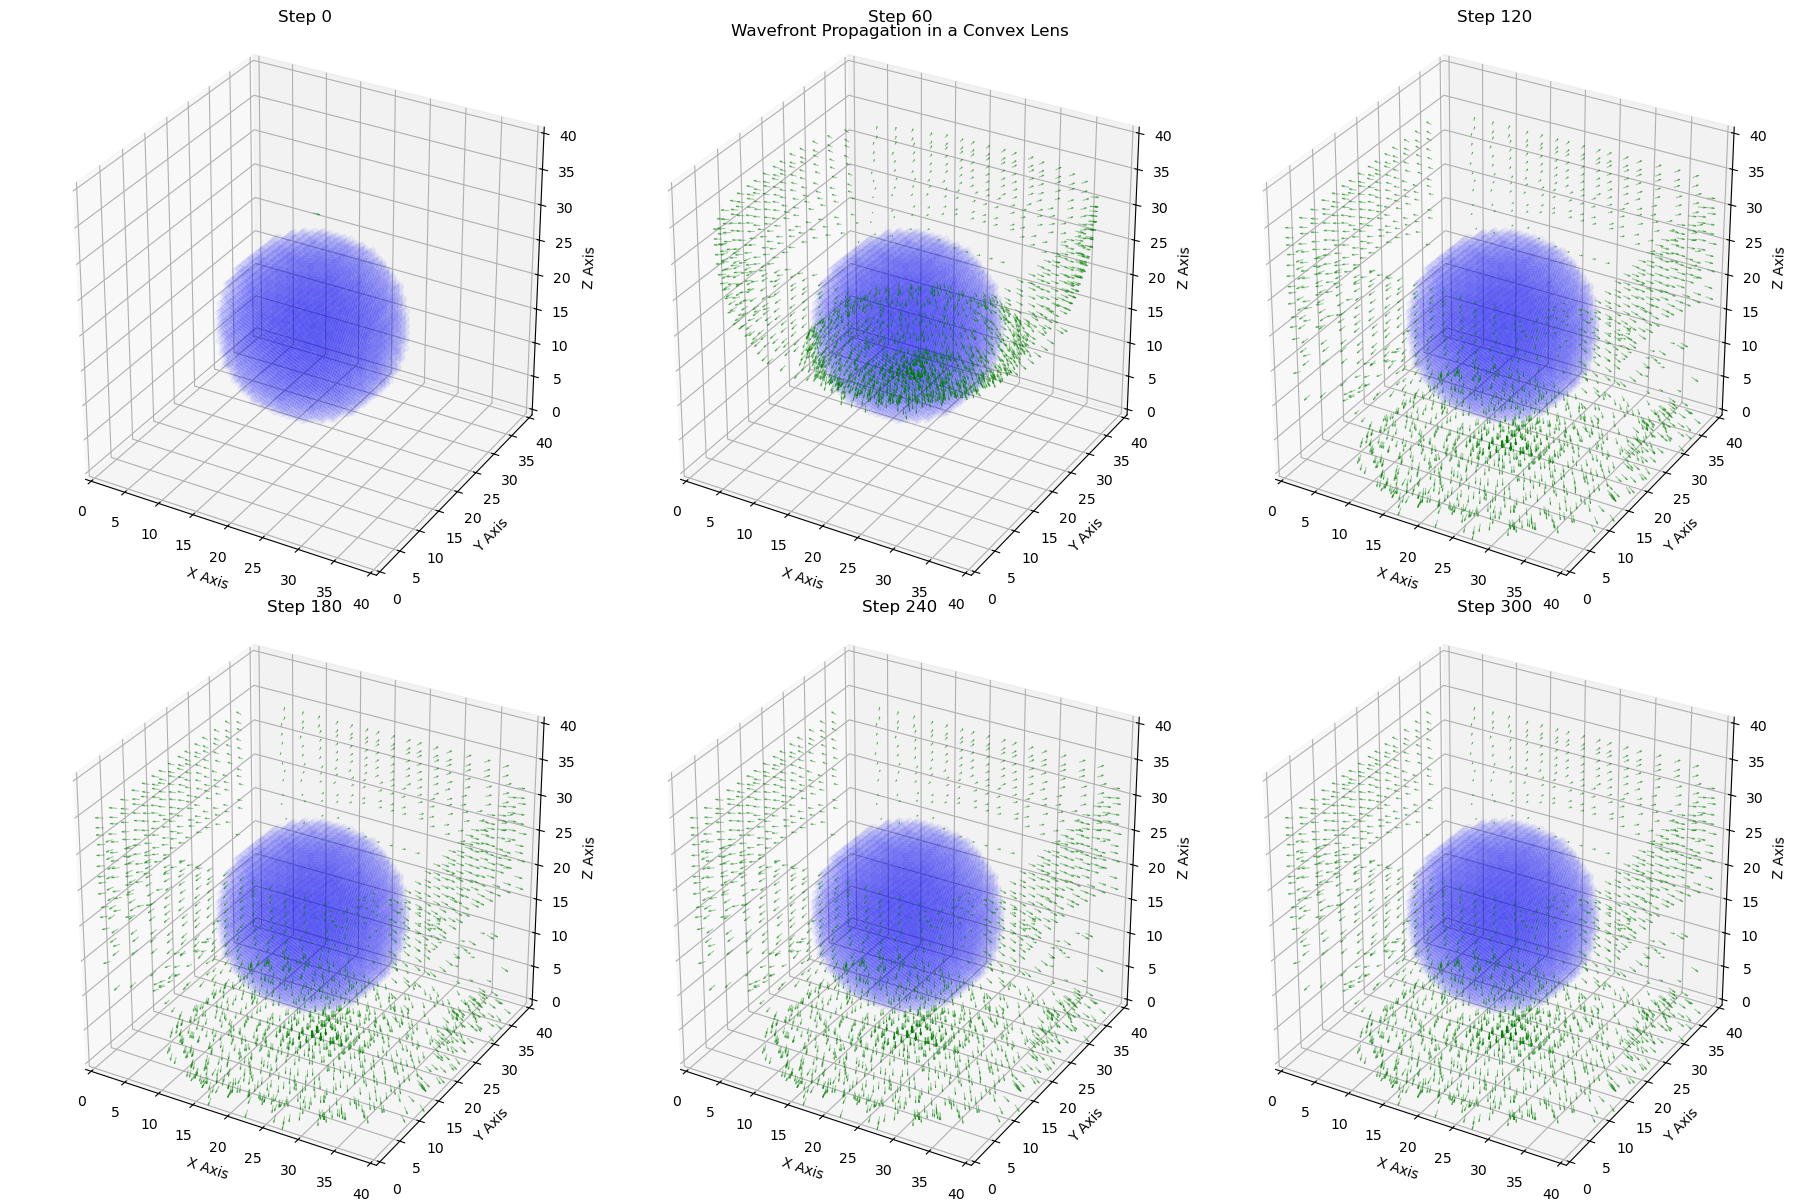

In [8]:
def show_propagation_results(convex_pos_res, convex_dir_res, IOR, num_show_images, fig_name):
    num_cols = min(num_show_images, 3)
    num_rows = (num_show_images + num_cols - 1) // num_cols
    num_steps = len(convex_pos_res) - 1

    show_indices = [i for i in range(0, num_steps+1, max(num_steps // (num_show_images-1), 1))]
    show_indices.append(num_steps)
    if len(show_indices) > num_show_images:
        show_indices = show_indices[:num_show_images]

    fig = plt.figure(figsize=(6 * num_cols, 6 * num_rows))
    
    for i, index in enumerate(show_indices):
        ax = fig.add_subplot(num_rows, num_cols, i + 1, projection='3d')
        ax.set_box_aspect([1,1,1])
        ax.set_xlim(0, IOR.shape[0])
        ax.set_ylim(0, IOR.shape[1])
        ax.set_zlim(0, IOR.shape[2])
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')
        ax.set_title(f"Step {index}")
        
        # Visualize 3D IOR field
        IOR_np = IOR.cpu().numpy() if IOR.is_cuda else IOR.numpy()
        x_points, y_points, z_points = np.where(IOR_np == sphere_ior)
        ax.scatter(x_points, y_points, z_points, color='blue', alpha=0.04)

        # Visualize Wavefront
        wavefront_positions = convex_pos_res[index].cpu().numpy() if convex_pos_res[index].is_cuda else convex_pos_res[index].numpy()
        wavefront_directions = convex_dir_res[index].cpu().numpy() if convex_dir_res[index].is_cuda else convex_dir_res[index].numpy()
        subsample_indices = np.arange(0, wavefront_positions.shape[0], 2)  # Subsampling every 2 data point
        ax.quiver(wavefront_positions[subsample_indices, 0], wavefront_positions[subsample_indices, 1], wavefront_positions[subsample_indices, 2], 
                  wavefront_directions[subsample_indices, 0], wavefront_directions[subsample_indices, 1], wavefront_directions[subsample_indices, 2],
                  length=1, color='green', normalize=True, linewidths=0.7, arrow_length_ratio=0.4, alpha=0.4)
        
    fig.tight_layout()
    fig.suptitle(fig_name)
    plt.show()

num_show_images = 6
show_propagation_results(wavefront_positions_list, wavefront_directions_list, ior_field, num_show_images, "Wavefront Propagation in a Convex Lens")

## Irradiance Computation

In [9]:
def update_irradiance(pos, irradiance, absorb_coeff, scatter_coeff, delta_t):
    # Retrieve the absorption and scattering coefficients at the current position
    indices = pos.int()
    absorption = absorb_coeff[indices[:, 0], indices[:, 1], indices[:, 2]]
    scattering = scatter_coeff[indices[:, 0], indices[:, 1], indices[:, 2]]

    # Calculate the decay factor based on the Beer-Lambert law
    decay_factor = torch.exp(-absorption * delta_t) * (1 - scattering)
    new_irradiance = irradiance * decay_factor
    return new_irradiance

initial_irradiance = torch.ones_like(initial_wavefront_positions[:, 0])  # Assume the initial irradiance is 1
irradiance_list = [initial_irradiance]

# Simulate the process of irradiance decay
for i in range(1, len(wavefront_positions_list)):
    new_irradiance = update_irradiance(
        wavefront_positions_list[i],
        irradiance_list[-1],
        absorb_coeff,
        scatter_coeff,
        test_delta_t
    )
    irradiance_list.append(new_irradiance)

In [10]:
def accumulate_irradiance_to_grid_vectorized(pos_list, irradiance_list, grid_shape):
    # Create a grid to store the accumulated irradiance
    irradiance_grid = torch.zeros(grid_shape, dtype=torch.float16, device=device)

    # Concatenate the positions and irradiances of all steps
    all_positions = torch.cat(pos_list, dim=0).long()
    all_irradiances = torch.cat(irradiance_list, dim=0)

    # Filter out the positions that are outside the grid boundaries
    valid_mask = (all_positions[:, 0] < grid_shape[0]) & (all_positions[:, 0] >= 0) & \
                 (all_positions[:, 1] < grid_shape[1]) & (all_positions[:, 1] >= 0) & \
                 (all_positions[:, 2] < grid_shape[2]) & (all_positions[:, 2] >= 0)

    valid_positions = all_positions[valid_mask]
    valid_irradiances = all_irradiances[valid_mask]

    # Accumulate the irradiance values to the grid
    indices = valid_positions[:, 0] * grid_shape[1] * grid_shape[2] + valid_positions[:, 1] * grid_shape[2] + valid_positions[:, 2]
    irradiance_grid.put_(indices, valid_irradiances, accumulate=True)

    return irradiance_grid


grid_shape = (num_x, num_y, num_z)
irradiance_grid_vectorized = accumulate_irradiance_to_grid_vectorized(wavefront_positions_list, irradiance_list, grid_shape)

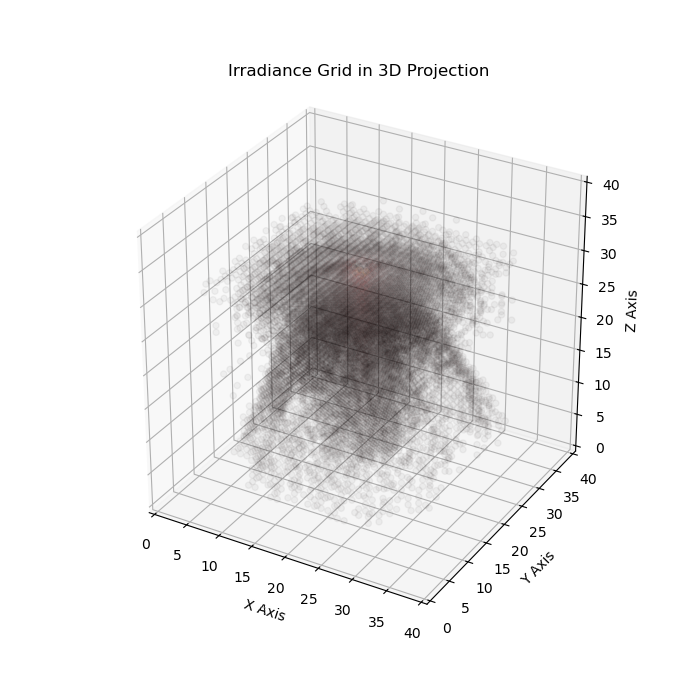

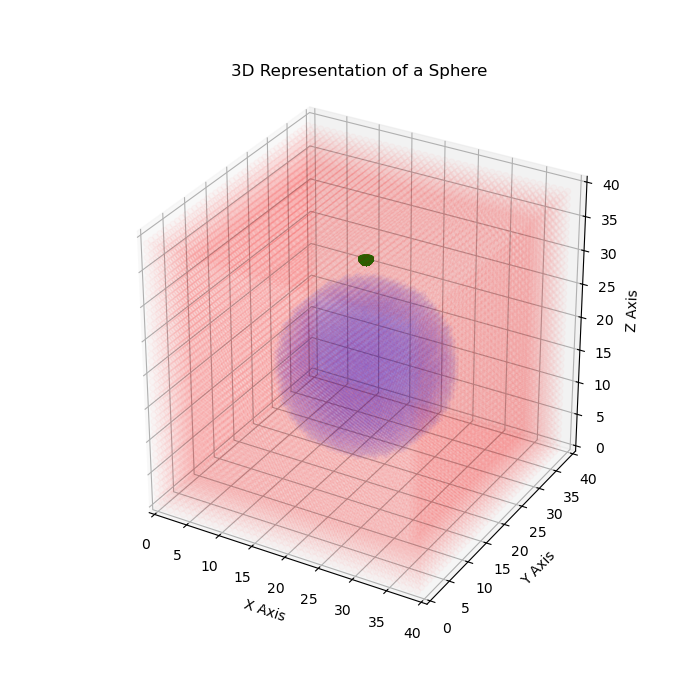

In [14]:
# Visualize irradiance grid in 3D projection
def show_irradiance_grid_3d(irradiance_grid, threshold=0.1):
    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect([1,1,1])
    ax.set_xlim(0, num_x)
    ax.set_ylim(0, num_y)
    ax.set_zlim(0, num_z)
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.set_title('Irradiance Grid in 3D Projection')


    irradiance_grid_np = irradiance_grid.cpu().numpy()
    x_points, y_points, z_points = np.where(irradiance_grid_np > threshold)
    ax.scatter(x_points, y_points, z_points, c=irradiance_grid_np[x_points, y_points, z_points], cmap='hot', alpha=0.04)
    # Colorbar
    
    plt.show()

show_irradiance_grid_3d(irradiance_grid_vectorized, threshold=4.0)
show_ior_field(ior_field, initial_wavefront_positions, initial_wavefront_directions)

In [13]:
# def accumulate_irradiance_to_grid(pos_list, irradiance_list, grid_shape):
#     # 创建一个与场景大小相同的张量来存储辐照度累积值
#     irradiance_grid = torch.zeros(grid_shape, dtype=torch.float16, device=device)
    
#     # 对每个步骤的波前位置和辐照度进行循环
#     for pos, irr in zip(pos_list, irradiance_list):
#         # 四舍五入或取整位置索引
#         indices = pos.long()

#         # 累积辐照度到网格中，简单的累加，更复杂的模型可能需要插值或分布算法
#         for idx, value in zip(indices, irr):
#             if (0 <= idx[0] < grid_shape[0] and
#                 0 <= idx[1] < grid_shape[1] and
#                 0 <= idx[2] < grid_shape[2]):
#                 irradiance_grid[idx[0], idx[1], idx[2]] += value

#     return irradiance_grid

# # 定义网格尺寸


# # 调用函数累积辐照度
# irradiance_grid = accumulate_irradiance_to_grid(wavefront_positions_list, irradiance_list, grid_shape)
